# SIGNAL PROCESSING TP5 - M2 AI
## To Do: image denoising in wavelet domain

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

---

## IMPORT

In [226]:
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import numpy as np
import librosa
import pywt

In [227]:
noise1, sr1 = librosa.load('noise1.wav', sr=None)
noise2, sr2 = librosa.load('noise2.wav', sr=None)
noise3, sr3 = librosa.load('noise3.wav', sr=None)

original_image = Image.open('barbara.jpg')
original_image_np = np.array(original_image)
image_flattened = original_image_np.flatten() / 255.0

noise1 = np.resize(noise1, original_image_np.shape)
noise2 = np.resize(noise2, original_image_np.shape)
noise3 = np.resize(noise3, original_image_np.shape)

SNR_LEVELS = [0, 10, 20]
NOISES = [noise1, noise2, noise3]

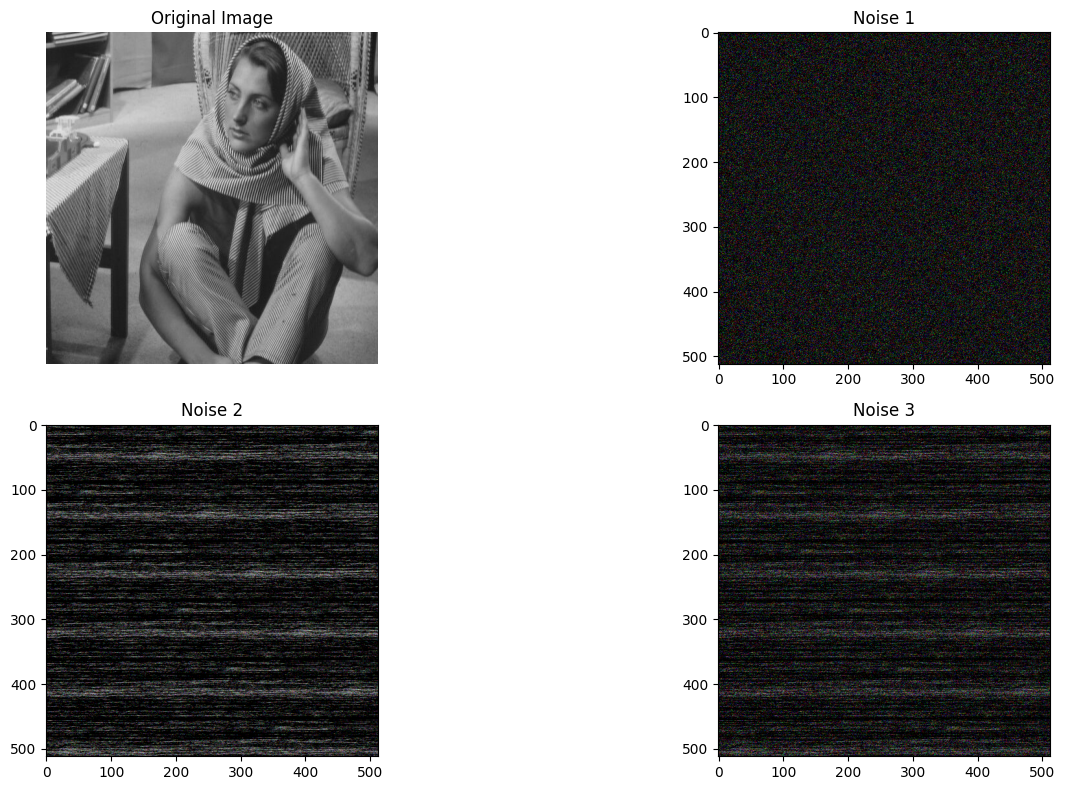

In [228]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, noise in enumerate(NOISES):
    plt.subplot(2, 2, i+2)
    plt.imshow(noise.clip(0,1), cmap='gray')
    plt.title(f"Noise {i+1}") 
plt.tight_layout()
plt.show()

## Simulate a noisy version of the image using the noises at various SNR Level (0 db, 10 dB and 20 dB)

In order to add a noise $n$ with a certain SNR to a signal $x$, we need to introduce a scaling factor parameter, here alpha:

$$
\text{SNR} = 10*\log_{10}(\frac{||x||_{2}^{2}}{\alpha^2||n||_{2}^{2}})
$$
And by solving the equation for $\alpha$, we find that :
$$
\alpha = \sqrt{\frac{||x||_{2}^{2}}{10^{\frac{\text{SNR}}{10}}||n||_{2}^{2}}}
$$
Therefore the noisy signal $y$ for a given level of SNR will be:
$$
y = x+\alpha *n
$$

In [153]:
def add_noise(signal, noise, snr_db):
    """
    Add noise to the signal with a given SNR value
    Args:
        signal: The clean signal.
        noise: The noise signal.
        snr_db: Desired SNR in dB.
    Returns:
        Noisy signal.
    """

    # Calculate the power of the signal and the noise
    spow = np.mean(signal**2)
    npow = np.mean(noise**2)
    
    # Calculate the scaling factor for noise
    scale_factor = np.sqrt(spow / (npow * 10 ** (snr_db / 10) ) )
    
    # Scale the noise and add it to the signal
    noisy_signal = signal + scale_factor * noise

    return noisy_signal.reshape(original_image_np.shape)

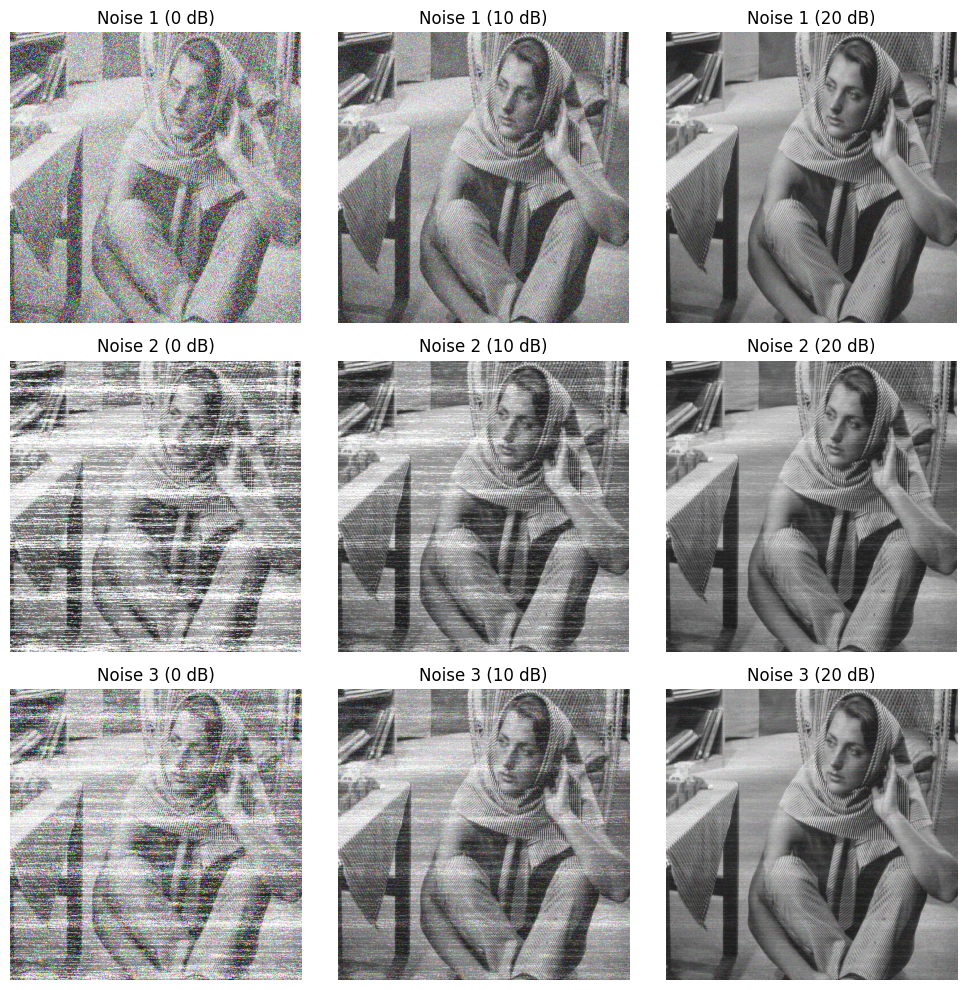

In [158]:
noisy_images = defaultdict(dict)  

plt.figure(figsize=(10, 10))
for i, noise in enumerate(NOISES):
    for j, snr in enumerate(SNR_LEVELS):

        noise_flattened = noise.flatten().clip(0,255)

        # Adjust the noise for the current SNR
        noisy_image = add_noise(image_flattened, noise_flattened, snr)
        noisy_images[i][snr] = noisy_image

        plt.subplot(3, 3, i * 3 + j + 1)
        plt.imshow(noisy_image.clip(0,1), cmap='gray')
        plt.title(f"Noise {i+1} ({snr} dB)")
        plt.axis('off')

plt.tight_layout()
plt.show()

## Denoise the image by performing hard thresholding and soft thresholding in the wavelet domain

### Hard Thresholding:
In hard thresholding, wavelet coefficients whose absolute value is below a given threshold are set to zero.

$$
y_i = 
\begin{cases} 
x_i & \text{if } |x_i| \geq \lambda \\
0 & \text{otherwise}
\end{cases}
$$

Where:
- $y_i$ is the thresholded coefficient.
- $x_i$ ​is the original wavelet coefficient.
- $\lambda$ is the threshold. 

### Soft Thresholding:
In soft thresholding, wavelet coefficients are shrunk by the threshold amount towards zero.
$$
y_i = \text{sign}(x_i) \times \max(0, |x_i| - \lambda)
$$

Where:
- $y_i$  is the thresholded coefficient.
- $x_i$  is the original wavelet coefficient.
- $\lambda$ is the threshold. 

In [216]:
print(pywt.families())

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


In [242]:
def wavelet_threshold(img, threshold, mode='hard', wavelet='db1', level=1):
    """Apply wavelet thresholding to denoise the image."""
    # Decompose the image into wavelet coefficients
    coeffs = pywt.wavedec2(img, wavelet, level=level)
    
    # Threshold the coefficients
    thresholded_coeffs = []
    for coeff in coeffs:  
        if isinstance(coeff, tuple):
            coeff = tuple(pywt.threshold(c, threshold, mode=mode) for c in coeff)
        else:
            coeff = pywt.threshold(coeff, threshold, mode=mode)
        thresholded_coeffs.append(coeff)
    
    # Reconstruct the image from the thresholded coefficients
    return pywt.waverec2(thresholded_coeffs, wavelet)

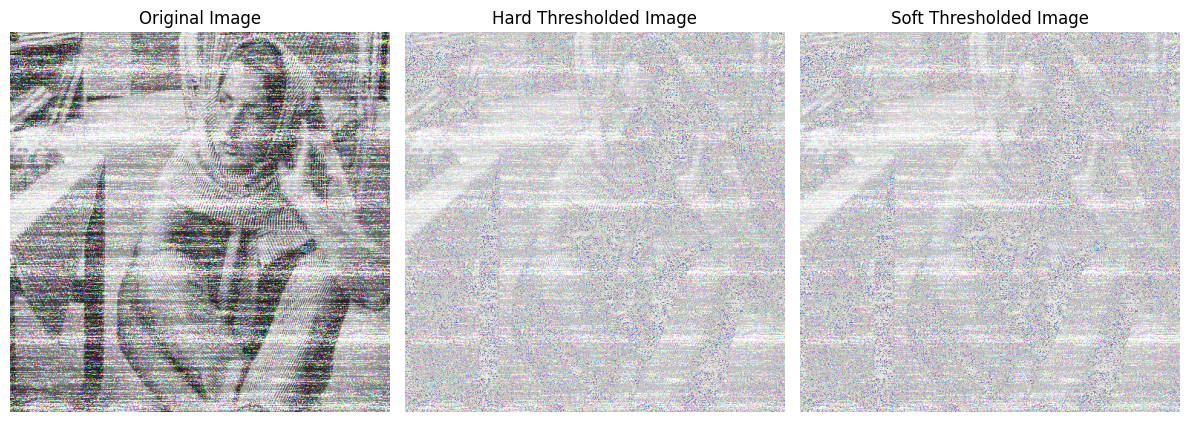

In [246]:
lambda_value = 0.01
example_image = noisy_images[2][0]

# Perform hard thresholding
hard_thresholded_img_corrected = wavelet_threshold(example_image, lambda_value, mode='hard')

# Perform soft thresholding
soft_thresholded_img_corrected = wavelet_threshold(example_image, lambda_value, mode='soft')

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.imshow(example_image.clip(0,1), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hard_thresholded_img_corrected.clip(0,1), cmap='gray')
plt.title("Hard Thresholded Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(soft_thresholded_img_corrected.clip(0,1), cmap='gray')
plt.title("Soft Thresholded Image")
plt.axis('off')

plt.tight_layout()
plt.show()

## Discuss the parameters (wavelet type, number of level, type of thresholding)
